In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [9]:
%%time
path_figs = './figs/2Mstd5/With_EFF_CALC'
save = False
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 0 ns, sys: 382 µs, total: 382 µs
Wall time: 607 µs


In [10]:
N,D = 2*10**5, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.25,0.25],[0.75,0.75],[0.75,0.25], [0.25,0.75]]
r_small = [0.07]*4
r_big = [0.24]*4
eligibilities = [1,1,2,2]
kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
               'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                  [2, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:441, Number of Points:200000


In [11]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,1,0,1.629626,-1.293973,-2.923599
1,0.602763,0.544883,0,1,-2.384515,-1.020078,-1.364437
2,0.423655,0.645894,2,0,-5.530881,-3.051910,2.478970
3,0.437587,0.891773,2,1,-1.298586,-5.279813,3.981228
4,0.963663,0.383442,0,0,5.668825,-2.601915,-8.270740


In [12]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.499785,0.499334,0.991740,0.501805,0.829068,0.843607,1.002015
std,0.288533,0.289177,0.817389,0.499998,5.049720,5.043390,7.116217
min,0.000003,0.000003,0.000000,0.000000,-24.011493,-23.477268,-29.649763
25%,0.249671,0.247699,0.000000,0.000000,-2.566408,-2.572481,-3.799226
50%,0.501024,0.498865,1.000000,1.000000,0.846886,0.842430,0.977325
75%,0.749132,0.750450,2.000000,1.000000,4.237301,4.257135,5.803491
max,0.999990,0.999999,2.000000,1.000000,24.583311,22.920856,30.644543


In [13]:
data.groupby('C').ITE.mean()

C
0    0.041436
1    0.982580
2    2.006184
Name: ITE, dtype: float64

In [14]:
#mpl.style.use(['seaborn-paper'])
#mpl.rcParams.update(mpl.rcParamsDefault)


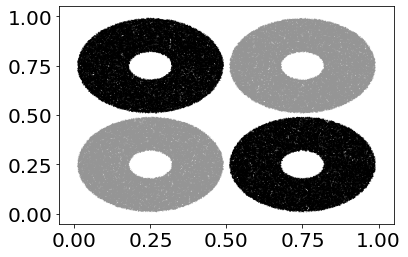

In [15]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [16]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [17]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 6min 2s, sys: 241 ms, total: 6min 2s
Wall time: 6min 2s


In [18]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,1,0,1.629626,-1.293973,-2.923599,0,1.358645,-0.270980
1,0.602763,0.544883,0,1,-2.384515,-1.020078,-1.364437,0,-0.209924,-2.174591
2,0.423655,0.645894,2,0,-5.530881,-3.051910,2.478970,0,2.265130,7.796010
3,0.437587,0.891773,2,1,-1.298586,-5.279813,3.981228,0,0.687209,-1.985794
4,0.963663,0.383442,0,0,5.668825,-2.601915,-8.270740,0,0.013385,-5.655440


### Model performance

In [19]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        0.976495  1.060467  1.085139  0.083972  0.108644
            1        0.976409  1.002278  1.128838  0.025869  0.152429
          1 0       -0.007109  0.983156  1.039699  0.990265  1.046808
            1        0.085050  0.933137  1.007627  0.848087  0.922576
          2 0       -0.019631  2.007356  1.873844  2.026987  1.893475
            1       -0.007403  2.147775  1.863081  2.155178  1.870484
1         0 0        1.023014  0.995052  0.843030  0.027962  0.179984
            1        0.945991  1.004256  0.868992 -0.058265  0.076999
          1 0        1.009321  0.023877  0.068122  0.985444  0.941199
            1        1.043459 -0.030885  0.090172  1.074344  0.953287
          2 0        1.955470  0.034613  0.059631  1.920857  1.895838
            1        1.992310 -0.124572  0.071413  2.116883  1.920897

### Apply clustering Box and Kmeans

In [20]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 2h 2min 52s, sys: 13.8 s, total: 2h 3min 6s
Wall time: 3min 39s


In [21]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,1,0,1.629626,-1.293973,-2.923599,0,1.358645,-0.270980,326,418
1,0.602763,0.544883,0,1,-2.384515,-1.020078,-1.364437,0,-0.209924,-2.174591,243,384
2,0.423655,0.645894,2,0,-5.530881,-3.051910,2.478970,0,2.265130,7.796010,281,430
3,0.437587,0.891773,2,1,-1.298586,-5.279813,3.981228,0,0.687209,-1.985794,387,61
4,0.963663,0.383442,0,0,5.668825,-2.601915,-8.270740,0,0.013385,-5.655440,188,437


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [22]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [23]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,0.114869,491.0,1.00,0.002455
1,1,0.072036,450.0,1.00,0.002250
2,2,0.046354,450.0,0.94,0.002250


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


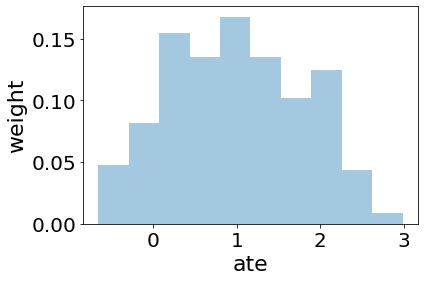

In [24]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 10
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, hist_kws = {'weights':box['Box-Weights'].values} , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



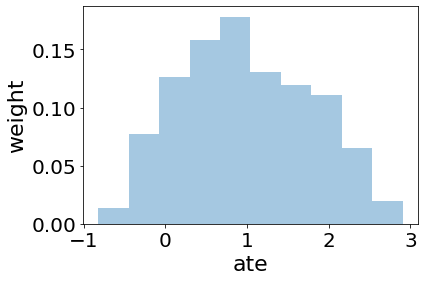

In [25]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], hist_kws={'weights':kmeans['Kmeans-Weights'].values},
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ate')
ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


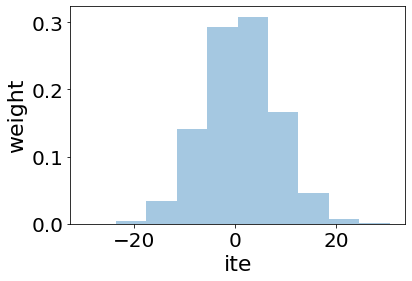

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = 10,hist_kws={'weights': np.ones(len(data))/len(data)},
                  kde = kde, ax = ax)
ax.set_xlabel('ite')
ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [27]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,441.00000,441.000000,441.000000,441.000000,441.000000
mean,220.00000,1.001847,453.514739,0.908875,0.002268
std,127.44999,0.799614,21.551110,0.151055,0.000108
min,0.00000,-0.660414,399.000000,0.439636,0.001995
25%,110.00000,0.349289,439.000000,0.847875,0.002195
50%,220.00000,0.956042,453.000000,1.000000,0.002265
75%,330.00000,1.621120,468.000000,1.000000,0.002340
max,440.00000,2.987686,520.000000,1.000000,0.002600


### Calculate ATT per Cluster not known Model Calculated CF

In [28]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


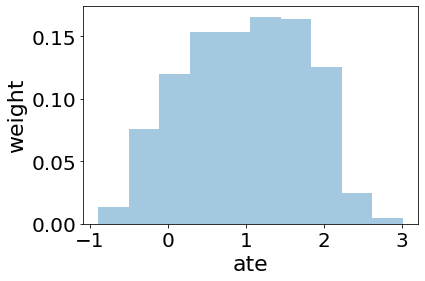

In [29]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ate')
ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


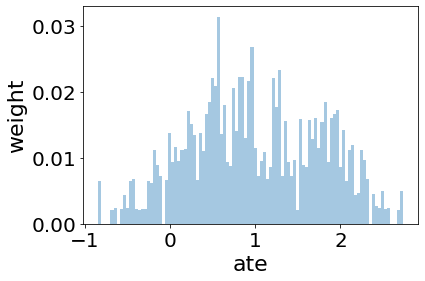

In [48]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], hist_kws={'weights':kmeans2['Kmeans-Weights'].values},
             bins = 100, kde = kde, ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')

if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

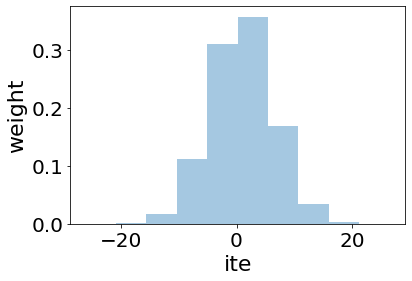

In [31]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax, hist_kws={'weights': np.ones(len(data))/len(data)})

ax.set_xlabel('ite')
ax.set_ylabel('weight')

if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Weighted Kmeans 6-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [32]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 3
for dd, name, name2,w in zip(all_data, names_to_give, names_to_find,weights):
    kmeans_clustering(dd, clusters = clusts, col_select = [name2], 
                      cluster_name = name, fit_kwargs={'sample_weight':dd[w].values} )

CPU times: user 308 ms, sys: 9.99 ms, total: 318 ms
Wall time: 160 ms


In [33]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,0.114869,491.0,1.0,0.002455,0
1,1,0.072036,450.0,1.0,0.002250,0


In [34]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,1,0,1.629626,-1.293973,-2.923599,0,1.358645,-0.270980,326,418
1,0.602763,0.544883,0,1,-2.384515,-1.020078,-1.364437,0,-0.209924,-2.174591,243,384


### 3 Clustering in the ITEs

In [35]:
data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [36]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [37]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,1,0,1.629626,-1.293973,-2.923599,0,1.358645,-0.270980,326,418,2,0,1,0,1,1
1,0.602763,0.544883,0,1,-2.384515,-1.020078,-1.364437,0,-0.209924,-2.174591,243,384,2,1,0,0,2,1


### Plot reconstruction of data

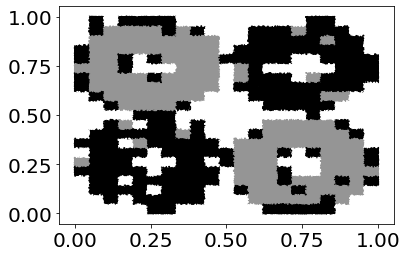

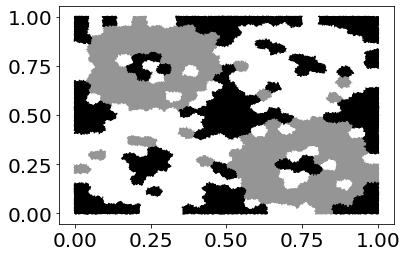

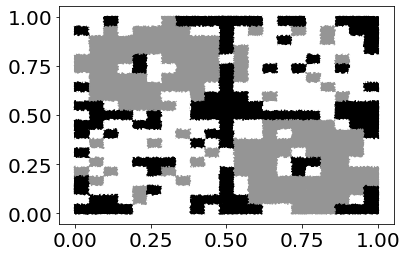

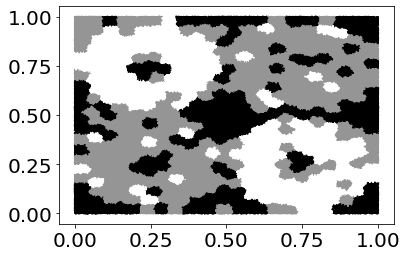

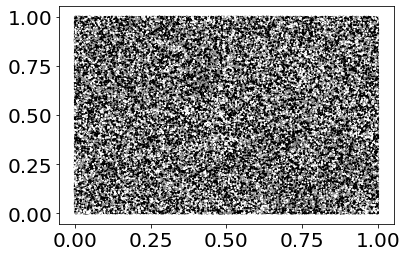

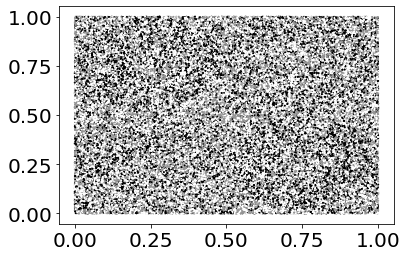

CPU times: user 38.7 s, sys: 989 ms, total: 39.7 s
Wall time: 38.7 s


In [38]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:

        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [39]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [40]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [41]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [42]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [43]:
errors.sort_values(by = 'mean')

,mean,std
Box-Cl2-err-True-ITE,0.252058,0.448665
Kmeans-Cl2-err-True-ITE,0.274807,0.445818
Box-Cl2-err-GDBR,0.304612,0.404281
Kmeans-Cl2-err-GDBR,0.311963,0.409881
Kmeans2-Cl2-err-GDBR,0.341660,0.446759
Kmeans2-Cl2-err-True-ITE,0.360308,0.423923
Box2-Cl2-err-GDBR,0.371409,0.445193
Box2-Cl2-err-True-ITE,0.380087,0.427635
ITE-2CTrue-err-GDBR,2.646870,1.910392
ITE-2CGDBR-err-True-ITE,3.409352,2.590609


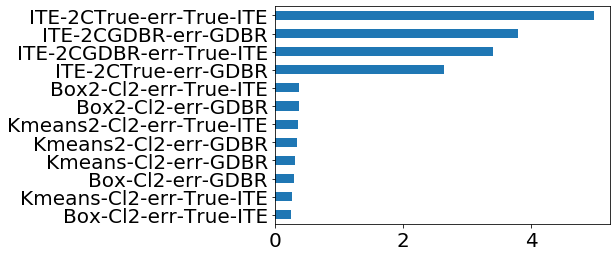

In [44]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [45]:
r1 = np.sqrt(0.14/3.14 + 0.1**2)
r1

0.23363644249377385

In [46]:
3.14*(0.07**2 + 0.222**2)

0.17013776000000003

In [47]:
0

0